In [1]:
! nvidia-smi

Thu Jan 13 16:26:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download andrewmvd/animal-faces

100% 694M/696M [00:25<00:00, 31.4MB/s]
100% 696M/696M [00:26<00:00, 28.1MB/s]


In [ ]:
! unzip animal-faces.zip

In [6]:
train_path = '/content/afhq/train'
test_path = '/content/afhq/val'

In [7]:
import tensorflow as tf 
import keras
from PIL import Image
import os
import pathlib 
import numpy as np 

tf.__version__

'2.7.0'

In [8]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [9]:
train_count = len(list(train_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
train_count, test_count

(14630, 1500)

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [11]:
cane = list(train_dir.glob('dog/*'))
img = Image.open(str(cane[0]))
width, height = img.size
print(f'{ width } x { height }') 

512 x 512


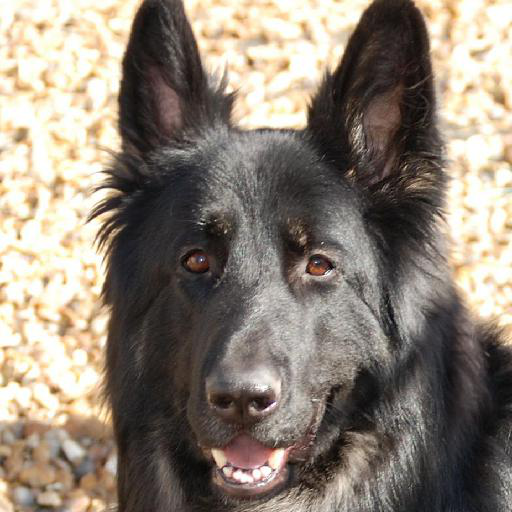

In [12]:
Image.open(cane[0])

In [13]:
batch_size = 32
img_height = height
img_width = width 

In [14]:
# making training dataset 

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14630 files belonging to 3 classes.
Using 11704 files for training.


In [15]:
# making testing dataset 

validation_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


In [16]:
class_name = train_ds.class_names
len(class_name)

3

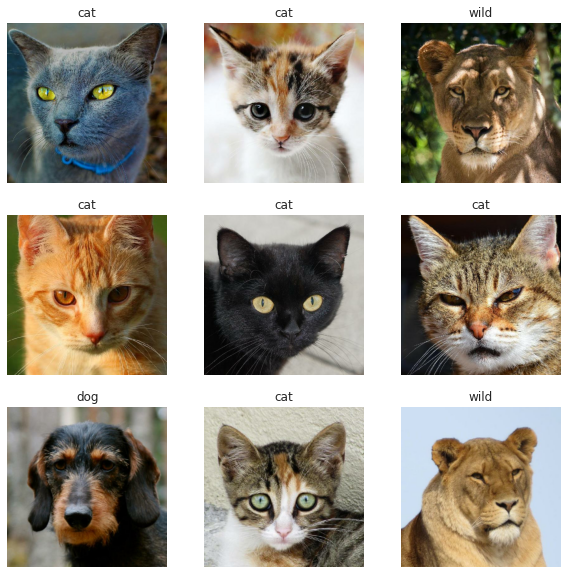

In [17]:
sns.set_theme()
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [18]:
for ib, lb in train_ds:
  print(ib.shape)
  print(lb.shape)
  break

(32, 512, 512, 3)
(32,)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Rescaling, Input

In [20]:
final = len(class_name)

model = Sequential([
                    Input(shape=(img_height, img_width, 3)),
                    Rescaling(1./255),
                    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.2),
                    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),
                    Dropout(0.5),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(final, activation='softmax')
])

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                    

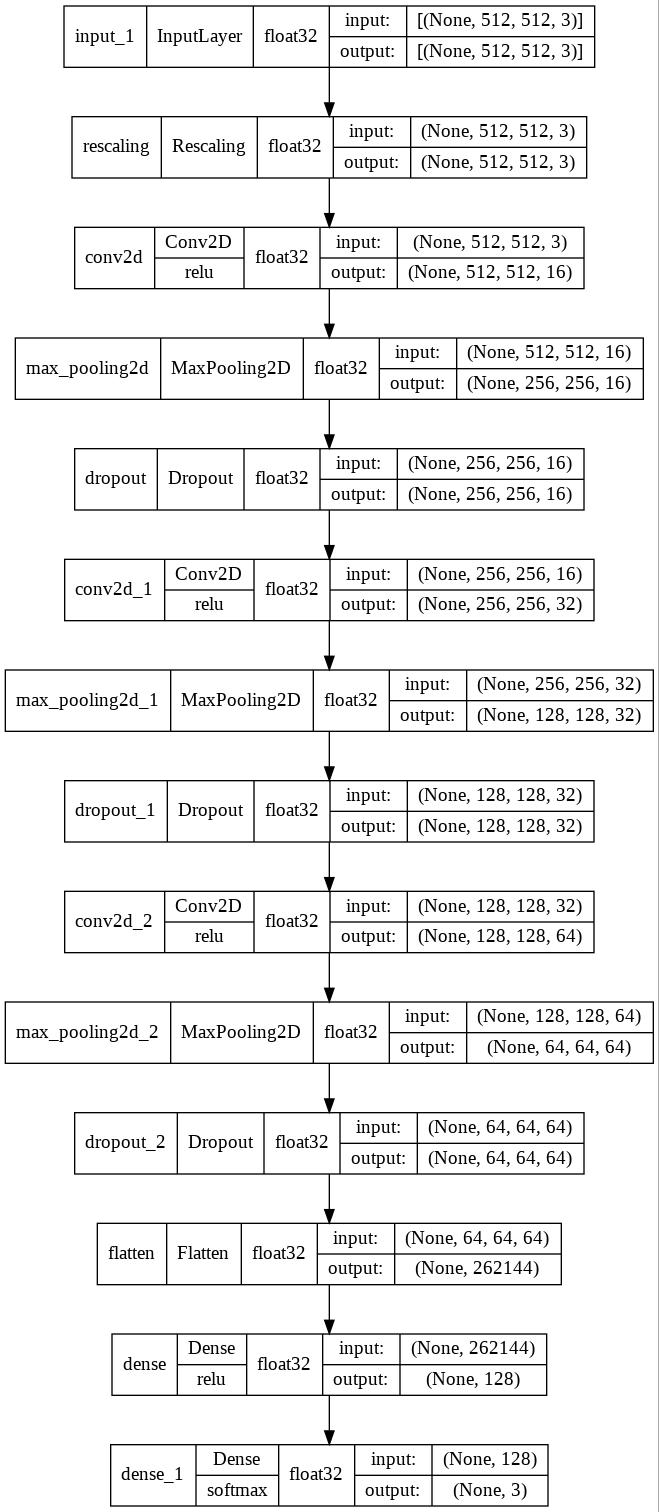

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file='model.jpg',
    show_shapes=True, 
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [26]:
early_stop = [
              keras.callbacks.EarlyStopping(
                  patience=2, 
                  monitor='val_loss',
                  restore_best_weights=True
              ),
              keras.callbacks.ModelCheckpoint(
                  'model.h5'
              ),
              keras.callbacks.TensorBoard(
                  log_dir='./logs'
              )
]

In [27]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    verbose=1,
    callbacks=early_stop
)

Epoch 1/20
366/366 [==============================] - 147s 369ms/step - loss: 0.8121 - accuracy: 0.7233 - val_loss: 0.3074 - val_accuracy: 0.8733
Epoch 2/20
366/366 [==============================] - 133s 362ms/step - loss: 0.2622 - accuracy: 0.9028 - val_loss: 0.1753 - val_accuracy: 0.9300
Epoch 3/20
366/366 [==============================] - 134s 365ms/step - loss: 0.1548 - accuracy: 0.9456 - val_loss: 0.1252 - val_accuracy: 0.9633
Epoch 4/20
366/366 [==============================] - 132s 360ms/step - loss: 0.1004 - accuracy: 0.9644 - val_loss: 0.1131 - val_accuracy: 0.9700
Epoch 5/20
366/366 [==============================] - 133s 362ms/step - loss: 0.0693 - accuracy: 0.9747 - val_loss: 0.1297 - val_accuracy: 0.9633
Epoch 6/20
366/366 [==============================] - 132s 359ms/step - loss: 0.0466 - accuracy: 0.9834 - val_loss: 0.1201 - val_accuracy: 0.9667


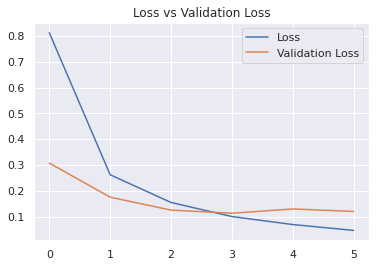

In [28]:
sns.set_theme()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Validation Loss')
plt.show()

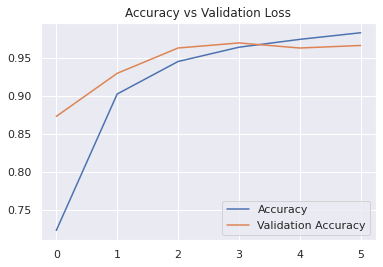

In [29]:
sns.set_theme()
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Validation Loss')
plt.show()

In [30]:
model.save('model.h5')